In [3]:
! pip install -q kaggle

In [4]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kirolossaleh","key":"578c6ffd02667d7fac93349f3ee6de0f"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d ogechukwu/voice

100% 801M/802M [00:33<00:00, 29.7MB/s]
100% 802M/802M [00:33<00:00, 24.9MB/s]


In [8]:
!unzip /content/voice.zip

Archive:  /content/voice.zip
  inflating: BVC_Voice_Bio_Public.xlsx  
  inflating: BVCvoicereadme.txt      
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE1.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE2.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE3.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE4.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE5.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV1.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV2.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV3.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV4.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV5.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4008_VE1.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4008_VE2.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4008_VE3.wav  
  inflat

In [9]:
import pandas as pd
import os
import librosa

audio_dataset_path='one_sentence/one_sentence/'


In [10]:
for filename in os.walk(audio_dataset_path):
        print(filename[2])

['S_01_4004_VV.wav', 'S_01_4458_VE.wav', 'S_01_4040_VV.wav', 'S_01_4611_VV.wav', 'S_01_4907_VV.wav', 'S_01_4292_VV.wav', 'S_01_4254_VE.wav', 'S_01_4012_VV.wav', 'S_01_4141_VE.wav', 'S_01_4421_VE.wav', 'S_01_4418_VV.wav', 'S_01_4567_VE.wav', 'S_01_4527_VV.wav', 'S_01_4215_VE.wav', 'S_01_4222_VV.wav', 'S_01_4001_VE.wav', 'S_01_4364_VV.wav', 'S_01_4958_VV.wav', 'S_01_4927_VE.wav', 'S_01_4389_VE.wav', 'S_01_4178_VV.wav', 'S_01_4026_VV.wav', 'S_01_4743_VE.wav', 'S_01_4950_VV.wav', 'S_01_4200_VV.wav', 'S_01_4059_VV.wav', 'S_01_4925_VE.wav', 'S_01_4067_VE.wav', 'S_01_4699_VV.wav', 'S_01_4586_VE.wav', 'S_01_4725_VE.wav', 'S_01_4471_VE.wav', 'S_01_4257_VE.wav', 'S_01_4642_VV.wav', 'S_01_4912_VV.wav', 'S_01_4353_VV.wav', 'S_01_4824_VE.wav', 'S_01_4684_VE.wav', 'S_01_4082_VV.wav', 'S_01_4285_VV.wav', 'S_01_4619_VE.wav', 'S_01_4113_VV.wav', 'S_01_4606_VV.wav', 'S_01_4030_VV.wav', 'S_01_4491_VE.wav', 'S_01_4340_VV.wav', 'S_01_4130_VV.wav', 'S_01_4205_VV.wav', 'S_01_4061_VE.wav', 'S_01_4620_VV.wav',

In [11]:
metadata=pd.read_csv('BVC_Voice_Bio_Public.csv')
metadata.drop(metadata.columns[metadata.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
metadata

,New_ID,Sex,Age,Ethnicity
0,4001,'Male',19,'Igbo'
1,4002,'Male',23,'Igbo'
2,4003,'Female',18,'Ikwerre'
3,4004,'Male',23,'Annang'
4,4005,'Female',17,'Igbo'
...,...,...,...,...
555,4993,'Male',18,'Igede'
556,4994,'Male',17,'Okirika'
557,4995,'Male',22,'Igbo'
558,4998,'Female',23,'Igbo'


# prepare the data 

In [12]:
import os
import pandas as pd

new_df = pd.DataFrame(columns=['ID', 'AudioPath', 'Sex'])

cdir = 'one_sentence/one_sentence/'

for new_id, Sex in zip(metadata['New_ID'], metadata['Sex']):
    audio_filenames = os.listdir(cdir)
    
    audio_filename = next((filename for filename in audio_filenames if str(new_id) in filename), None)

    if audio_filename is not None:
        audio_path = os.path.join(cdir, audio_filename)
        new_df = new_df.append({'ID': new_id, 'AudioPath': audio_path, 'Sex': Sex}, ignore_index=True)

print(new_df)


<ipython-input-12-cb507dac133f>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'ID': new_id, 'AudioPath': audio_path, 'Sex': Sex}, ignore_index=True)
<ipython-input-12-cb507dac133f>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'ID': new_id, 'AudioPath': audio_path, 'Sex': Sex}, ignore_index=True)
<ipython-input-12-cb507dac133f>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'ID': new_id, 'AudioPath': audio_path, 'Sex': Sex}, ignore_index=True)
<ipython-input-12-cb507dac133f>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'ID': n

       ID                                   AudioPath       Sex
0    4001  one_sentence/one_sentence/S_01_4001_VE.wav    'Male'
1    4003  one_sentence/one_sentence/S_01_4003_VV.wav  'Female'
2    4004  one_sentence/one_sentence/S_01_4004_VV.wav    'Male'
3    4006  one_sentence/one_sentence/S_01_4006_VV.wav  'Female'
4    4007  one_sentence/one_sentence/S_01_4007_VV.wav  'Female'
..    ...                                         ...       ...
330  4990  one_sentence/one_sentence/S_01_4990_VE.wav    'Male'
331  4991  one_sentence/one_sentence/S_01_4991_VE.wav    'Male'
332  4994  one_sentence/one_sentence/S_01_4994_VV.wav    'Male'
333  4998  one_sentence/one_sentence/S_01_4998_VE.wav  'Female'
334  4999  one_sentence/one_sentence/S_01_4999_VE.wav    'Male'

[335 rows x 3 columns]


<ipython-input-12-cb507dac133f>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'ID': new_id, 'AudioPath': audio_path, 'Sex': Sex}, ignore_index=True)
<ipython-input-12-cb507dac133f>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'ID': new_id, 'AudioPath': audio_path, 'Sex': Sex}, ignore_index=True)
<ipython-input-12-cb507dac133f>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'ID': new_id, 'AudioPath': audio_path, 'Sex': Sex}, ignore_index=True)
<ipython-input-12-cb507dac133f>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'ID': n

In [13]:
new_df

,ID,AudioPath,Sex
0,4001,one_sentence/one_sentence/S_01_4001_VE.wav,'Male'
1,4003,one_sentence/one_sentence/S_01_4003_VV.wav,'Female'
2,4004,one_sentence/one_sentence/S_01_4004_VV.wav,'Male'
3,4006,one_sentence/one_sentence/S_01_4006_VV.wav,'Female'
4,4007,one_sentence/one_sentence/S_01_4007_VV.wav,'Female'
...,...,...,...
330,4990,one_sentence/one_sentence/S_01_4990_VE.wav,'Male'
331,4991,one_sentence/one_sentence/S_01_4991_VE.wav,'Male'
332,4994,one_sentence/one_sentence/S_01_4994_VV.wav,'Male'
333,4998,one_sentence/one_sentence/S_01_4998_VE.wav,'Female'


# Data augmentation 


In [14]:
import numpy as np
import librosa

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(new_df.AudioPath)[1]
data, sample_rate = librosa.load(path)


# feature extraction 

In [15]:
def extract_features(data):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally


    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally


    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally


    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result

def get_features(path):
    data, sample_rate = librosa.load(path)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 


    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) 
    
    return result

In [16]:
X, Y = [], []
for path, Sex in zip(new_df.AudioPath, new_df.Sex):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(Sex)

In [17]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.134950,0.541973,0.590975,0.629498,0.554340,0.484941,0.414414,0.411719,0.403977,0.492537,...,0.003427,0.002742,0.003128,0.003828,0.004409,0.004212,0.003110,0.001608,0.000147,'Male'
1,0.157595,0.571726,0.630003,0.659779,0.586265,0.531414,0.434291,0.425928,0.418250,0.514427,...,0.003838,0.003209,0.003627,0.004274,0.004799,0.004651,0.003572,0.002094,0.000585,'Male'
2,0.130268,0.495097,0.560843,0.628934,0.613584,0.476994,0.448549,0.397056,0.402286,0.385671,...,0.000430,0.000798,0.001017,0.000631,0.000811,0.001076,0.001057,0.000415,0.000033,'Male'
3,0.055257,0.510395,0.496585,0.430653,0.482498,0.536145,0.543438,0.455384,0.360789,0.422762,...,0.000334,0.000304,0.000394,0.000452,0.000346,0.000174,0.000087,0.000087,0.000013,'Female'
4,0.211109,0.675349,0.674614,0.621709,0.637788,0.632958,0.594809,0.541062,0.499713,0.533798,...,0.002676,0.002543,0.002710,0.002676,0.002558,0.002416,0.002419,0.002367,0.002283,'Female'


In [18]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# One hot encoding for classification 

In [19]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape



((753, 162), (753, 2), (252, 162), (252, 2))

# scaling or Normalize the features 

In [21]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((753, 162), (753, 2), (252, 162), (252, 2))

# reshaping the data for the model 

In [22]:


#. The added dimension indicates the number of channels or features, which is required by models that work with multidimensional input data, such as CNNs.

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape



((753, 162, 1), (753, 2), (252, 162, 1), (252, 2))

# Model.add(Conv1D(...)) adds a 1D convolutional layer to the model.
# 256 specifies the number of filters in the convolutional layer. Each filter learns to detect different patterns or features in the input data.
# kernel_size=5 sets the size of the convolutional kernel or filter. In this case, it is 5, meaning the filter will slide over a sequence of 5 elements at a time.
# strides=1 defines the step size of the filter during convolution. A stride of 1 means the filter moves one element at a time.
# padding='same' specifies the padding mode for the convolution operation. 'same' padding pads the input sequence with zeros in such a way that the output sequence has the same length as the input.
# activation='relu'
# input_shape=(x_train.shape[1], 1) defines the shape of the input data. x_train.shape[1] represents the length of each input sequence, and the 1 indicates that the input has a single channel (since it's a 1D convolutional layer).
# model.add(MaxPooling1D(...)) adds a 1D max pooling layer to the model.
# pool_size=5 sets the size of the pooling window. In this case, it is 5, meaning the maximum value in each window of 5 elements will be selected.
# strides=2 defines the step size of the pooling window during pooling. A stride of 2 means the pooling window moves two elements at a time.
# padding='same' specifies the padding mode for the pooling operation. 'same' padding pads the input sequence with zeros in such a way that the output sequence has the same length as the input.
# model.add(Dropout(0.2)): This line adds a dropout layer with a dropout rate of 0.2. Dropout is a regularization technique that randomly sets a fraction of input units to 0 during training, which helps prevent overfitting (he drop 20% from the weights)
# model.add(Flatten()): This line adds a flatten layer to the model. It reshapes the output of the previous layer into a 1D vector, preparing it for the subsequent dense layers.
# model.add(Dense(...)) adds a fully connected layer to the model.
# units=48 specifies the number of neurons or units in the dense layer. Each neuron in the layer is connected to every neuron in the previous layer

In [30]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax')) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ...

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 21, 128)         

# monitor='loss': The quantity to monitor for learning rate adjustment. In this case, it is the loss value.
# factor=0.4: The factor by which the learning rate will be reduced. When the monitored quantity stops improving, the learning rate will be multiplied by this factor.
# verbose=0: Controls the verbosity of the callback's output. In this case, no output will be printed during training.
# patience=2: The number of epochs with no improvement after which the learning rate will be reduced. If no improvement is observed for patience consecutive epochs, the learning rate will be adjusted.
# min_lr=0.0000001: The minimum learning rate allowed. The learning rate will not be reduced below this value.
# batch_size=64: The number of samples per gradient update. It determines how many training examples are processed at once before the model's parameters are updated.
# epochs=50: The number of times the entire training dataset is passed through the model during training.
# In the context of machine learning, the learning rate is a hyperparameter that determines the step size at which a model's parameters are updated during the training process. A higher learning rate can result in faster convergence but may risk overshooting the optimal solution, while a lower learning rate can lead to slower convergence but potentially more accurate results. The learning rate is a crucial parameter to tune for optimal model performance.
# By using the ReduceLROnPlateau callback, you can automatically adjust the learning rate during training based on the behavior of the loss metric. If the loss metric does not improve for a certain number of epochs (as determined by other parameters like patience), the learning rate will be reduced by a factor (as determined by other parameters like factor). This adaptive learning rate adjustment can help the model to converge more effectively and potentially reach a better solution.

In [31]:
rlrp = ReduceLROnPlateau(monitor='loss', min_lr=0.0000001)
#rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])

# Print the shape of true labels and predicted output
y_pred = model.predict(x_train)
print("Shape of y_train:", y_train.shape)
print("Shape of y_pred:", y_pred.shape)


Epoch 1/25
12/12 [==============================] - 9s 512ms/step - loss: 0.5837 - accuracy: 0.7384 - val_loss: 0.4909 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 2/25
12/12 [==============================] - 6s 508ms/step - loss: 0.5250 - accuracy: 0.7437 - val_loss: 0.4687 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 3/25
12/12 [==============================] - 6s 512ms/step - loss: 0.4522 - accuracy: 0.7928 - val_loss: 0.4593 - val_accuracy: 0.7897 - lr: 0.0010
Epoch 4/25
12/12 [==============================] - 5s 456ms/step - loss: 0.4333 - accuracy: 0.8101 - val_loss: 0.4381 - val_accuracy: 0.8016 - lr: 0.0010
Epoch 5/25
12/12 [==============================] - 7s 560ms/step - loss: 0.4114 - accuracy: 0.8207 - val_loss: 0.4367 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 6/25
12/12 [==============================] - 6s 485ms/step - loss: 0.3787 - accuracy: 0.8499 - val_loss: 0.4043 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 7/25
12/12 [==============================] - 9s 747ms/step - lo

# loss: The loss value indicates the average loss computed during the training process. It represents how well the model is fitting the training data. In this case, the reported value of 0.5837 suggests that, on average, the model's predictions are deviating from the actual training labels by that amount (considering the specific loss function used).

# val_loss: The val_loss value represents the average loss computed on the validation dataset. The validation dataset is a separate set of data that the model has not seen during training. It serves as a proxy for the model's performance on unseen data. The reported value of 0.4909 indicates the average deviation between the model's predictions and the validation labels.

8/8 [==============================] - 1s 77ms/step - loss: 0.3114 - accuracy: 0.8929
Accuracy of our model on test data :  89.28571343421936 %


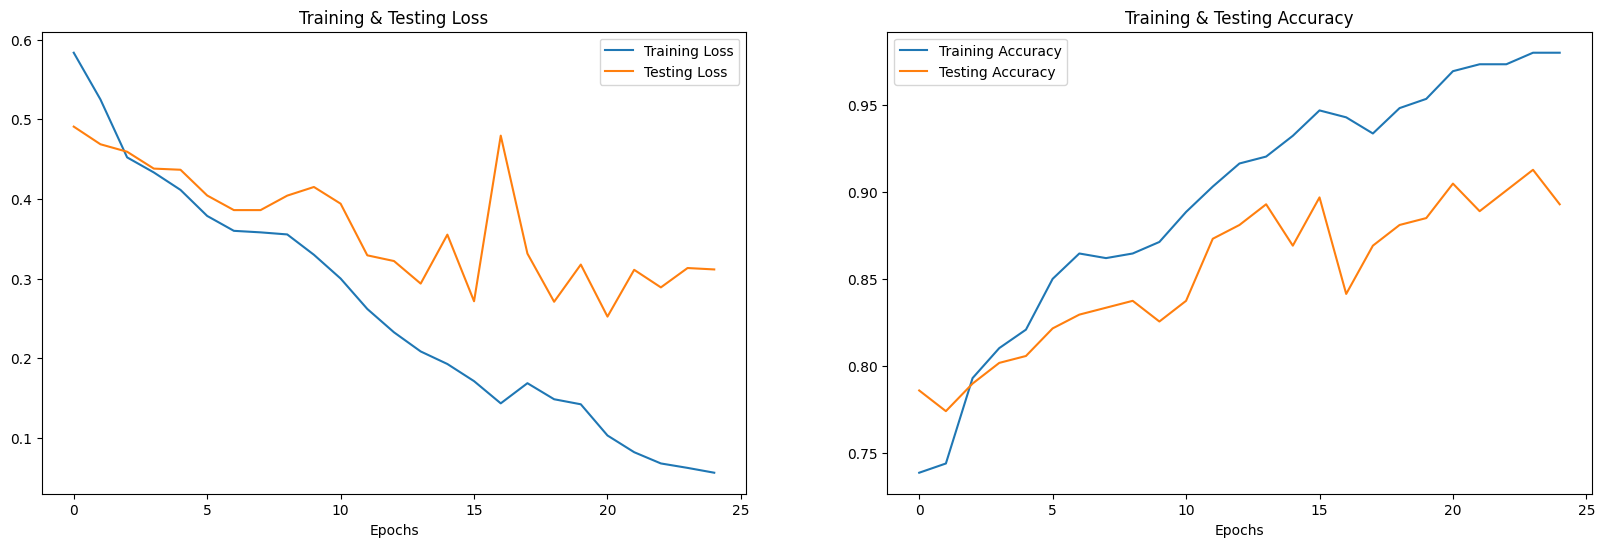

In [32]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()